### Trying to encode chaos into images
Pretty basic for now


In [64]:
from pytisean import tiseano, tiseanio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy import integrate

import seaborn as sns
import matplotlib.image as mpimg

from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
import matplotlib.animation as animation

from matplotlib.animation import FFMpegWriter

%matplotlib inline


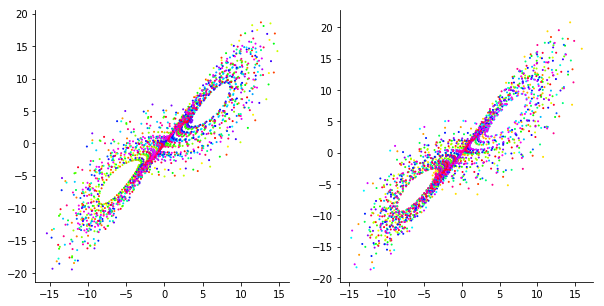

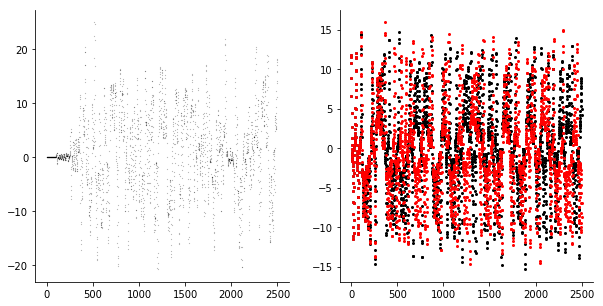

In [4]:
angle=0.0 
max_time=100.0
sigma=10.0 
beta=4./3 
rho=28.0

def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

#Start by generating some initial conditions, scaled
x0 = -15 + 30 * np.array([[  0.02,   0.01,   0.002]])

# Solve for the trajectory
t = np.linspace(0, max_time, int(60*max_time))
x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                  for x0i in x0])

x, y, z = x_t[0,:,:].T
L1 = pd.DataFrame(dict(X = x, Y = y, Z = z))

# Now we can throw out the first 1000 steps and snag those coordinates
# for the new initial conditions of the sequence
x0 = [[L1.X[1000], L1.Y[1000], L1.Z[1000]]]

# Solve for the trajectories with the new initial conditions
t = np.linspace(0, max_time, int(25*max_time))
x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                  for x0i in x0])

x, y, z = x_t[0,:,:].T
L2 = pd.DataFrame(dict(X2 = x, Y2 = y, Z2 = z))

# Solve for the trajectories with the new initial conditions plus pertubations
pert = 10**(-3)

x0 = [[L1.X[1000]+pert, L1.Y[1000]+pert, L1.Z[1000]+pert]]
t = np.linspace(0, max_time, int(25*max_time))
x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                  for x0i in x0])

x, y, z = x_t[0,:,:].T
L3 = pd.DataFrame(dict(X3 = x, Y3 = y, Z3 = z))

f, (ax2, ax3) = plt.subplots(1,2,figsize = (10,5))
ax2.scatter(L2.X2, L2.Y2, c = L2.index, s = 1, cmap='hsv')
ax3.scatter(L3.X3, L3.Y3, c = L3.index, s = 1, cmap='hsv')
sns.despine()

f, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))
ax1.plot(L2.X2 - L3.X3, 'ok', markersize = 0.1)
ax2.plot(L2.X2, 'ok', markersize = 2)
ax2.plot(L3.X3, 'or', markersize = 2)

#ax2.set_xlim([1000, 1100])
sns.despine()

(-0.25, 0.25)

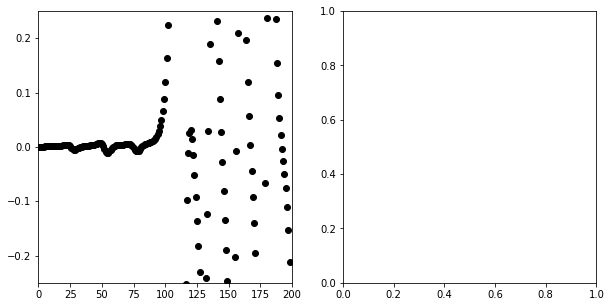

In [36]:
f, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))
ax1.plot(L2.X2 - L3.X3, 'ok')
ax1.set_xlim([0,200])
ax1.set_ylim([-.25,.25])

#### First we read in an image and generate a chaotic attractor
Here we had the idea to cheat initially and just create two chaotic series, with slightly offset time intervals.

In [3]:
img = mpimg.imread('demo.png')
numPixels = np.size(img[20:60,40:80,0].ravel())
imgMap = pd.DataFrame(dict(Time = np.arange(0,numPixels), 
                  R = img[20:60,40:80,0].ravel(), 
                  G = img[20:60,40:80,1].ravel(), 
                  B = img[20:60,40:80,2].ravel(),
                  A = img[20:60,40:80,3].ravel()))

lorenz, err = tiseano('lorenz', '-l3200', '-f25')
Time = np.arange(0,len(lorenz))
LDF = pd.DataFrame(dict(Time = Time, x=lorenz[:,0], 
                  y = lorenz[:,1], z = lorenz[:,2]))


Time = np.arange(0,len(lorenz))
LDF = pd.DataFrame(dict(Time = Time, x=lorenz[:,0], 
                  y = lorenz[:,1], z = lorenz[:,2]))
lorenz2, err = tiseano('lorenz', '-l3200', '-f26')



Time2 = np.arange(0,len(lorenz2))
LDF2 = pd.DataFrame(dict(Time = Time, x=lorenz2[:,0], 
                  y = lorenz2[:,1], z = lorenz2[:,2]))

#ax.scatter(LDF.x, LDF.y, c = LDF.Time, s = 1.5, cmap='PuOr')

nx, ny = (25, 25)
x = np.linspace(LDF.x.min().round(), LDF.x.max().round(), nx)
y = np.linspace(LDF.y.min().round(), LDF.y.max().round(), ny)
xv, yv = np.meshgrid(x, y)
#xv, yv = np.meshgrid(x, y, sparse=True)  # make sparse output arrays

snip = img[20:60,40:80,0]
f, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))
ax1.plot(xv.flat,yv.flat,'.k', alpha = 0.2)
ax1.scatter(LDF.x, LDF.y, c = LDF.Time, s = 1.5, cmap='PuOr')
ax2.scatter(LDF2.x, LDF2.y, c = LDF.Time, s = 1.5, cmap='PuOr')

sns.despine()

FileNotFoundError: [Errno 2] No such file or directory: 'demo.png'

### This is the meaty bit
where we take a subset of the training image and do the mapping from one series to another. It takes a minute or so to run given the matching algorithm is pretty unoptimized.

### Conduct image row by row permutations

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


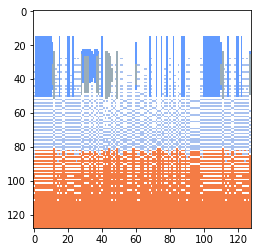

In [67]:
angle=0.0 
max_time=30.0
sigma=10.0 
beta=4./3 
rho=28.0
x0_0 = x0 = -15 + 30 * np.array([[  0.02,   0.01,   0.002]])

def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

def lorenz_integrate(x0, max_time, numSteps):
    t = np.linspace(0, max_time, int(numSteps*max_time))
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
        for x0i in x0])
    x, y, z = x_t[0,:,:].T
    return x, y, z
    
def forwardLorenz(x, y, z, start, pert_mult, max_time, numSteps):
    pert = random.random() * pert_mult
    x0_n = [[x[start]+pert, y[start]+pert, z[start]+pert]]
    x, y, z = lorenz_integrate(x0_n, max_time, numSteps)
    return x, y, z

def importImage(image_name):
    img = mpimg.imread(image_name)
    return img


img = importImage('demo.png')
newImg = np.empty_like(img)
x_0, y_0, z_0 = lorenz_integrate(x0_0, 150, 60)

writer = FFMpegWriter(fps=15)
fig = plt.figure()
with writer.saving(fig, "imgTest.mp4", 100):
    for i in range(100):
        img = importImage('demo.png')

        x_n, y_n, z_n = forwardLorenz(x_0, y_0, z_0, i, 10**(-2), 150, 60)
        print(i)
        for band in [0,1,2]:
            for row in np.arange(len(img)):
                for time in np.arange(1,len(img)): 
                        thisRow = img[row,:,band]
                        x1 = x_0[time]
                        xdif = np.abs(x_n[:len(img)] - x1)
                        sortedDif = np.sort(xdif)
                        variation = sortedDif[0]
                        img[row,time,band] = thisRow[np.where(xdif==variation)[0]]

        plt.imshow(img)
        writer.grab_frame()

    


In [41]:
pert = random.random() * 10**(-2)
pert

0.008645890620297527

In [65]:
img = mpimg.imread('demo.png')

newImg = img[0,:,0]
for row in np.arange(len(img)):
    mapRow1 = img[row,:,0]
    mapRow2 = img[row,:,0]
    # Now we can throw out the first 1000 steps and snag those coordinates
    # for the new initial conditions of the sequence
    x0 = [[L1.X[1000], L1.Y[1000], L1.Z[1000]]]

    # Solve for the trajectories with the new initial conditions
    t = np.linspace(0, max_time, int(128))
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                  for x0i in x0])

    x, y, z = x_t[0,:,:].T
    L2 = pd.DataFrame(dict(X2 = x, Y2 = y, Z2 = z))

    # Solve for the trajectories with the new initial conditions plus pertubations
    pert = random.random()*10**(-4)

    x0 = [[L1.X[1000]+pert, L1.Y[1000]+pert, L1.Z[1000]+pert]]

    t = np.linspace(0, max_time, int(128))
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                  for x0i in x0])
    
    x, y, z = x_t[0,:,:].T
    L3 = pd.DataFrame(dict(X3 = x, Y3 = y, Z3 = z))
    
    for time in range(128):
        x1 = L3.X3[time]
        xdif = np.abs(L2.X2 - x1)
        sortedDif = np.sort(xdif)
        variation = sortedDif[0]
        mapRow1[time] = mapRow2[np.where(xdif==variation)[0]]
        
    newImg = np.append(newImg,mapRow1, axis = 0)
    

NameError: name 'L1' is not defined

### Now that the remapping is finshed
we can take a look at the output. We can also run the reshaping in reverse to make sure the garbled output is happening correctly. Its a mess, but its a start.

Next steps are to advance the series properly using an ODE and integrate from slightly different initial conditions. Also, given the series starts to diverge the longer it runs, we can try and do this image noise introduction one line at a time.

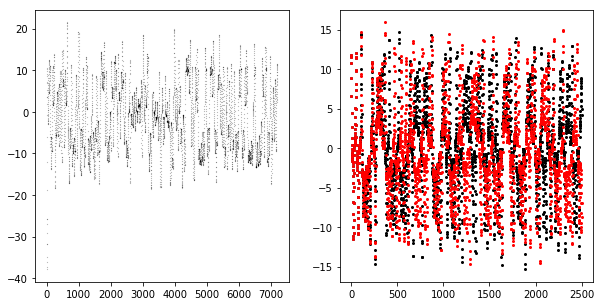

In [59]:
f, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))
ax1.plot(x_0 - x_n, 'ok', markersize = 0.1)
ax2.plot(L2.X2, 'ok', markersize = 2)
ax2.plot(L3.X3, 'or', markersize = 2)

In [56]:
thisBand

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       ..., 
       [ 0.95686275,  0.95686275,  0.95686275, ...,  0.95686275,
         0.95686275,  0.95686275],
       [ 0.95686275,  0.95686275,  0.95686275, ...,  0.95686275,
         0.95686275,  0.95686275],
       [ 0.95686275,  0.95686275,  0.95686275, ...,  0.95686275,
         0.95686275,  0.95686275]], dtype=float32)

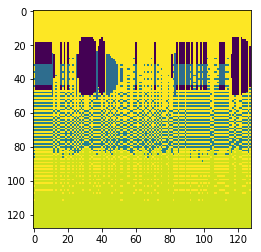

In [57]:
plt.imshow(thisBand.reshape(128,128))

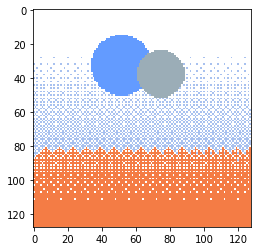

In [116]:
img = mpimg.imread('demo.png')
plt.imshow(img)

### The x-values start to get crazy over time
This makes sense, if we were only using the say first 500 values, we would be in better shape. The line by line idea may help a lot.

### Here'e the full image and some code to cut it up into its colors

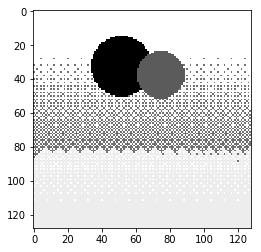

In [70]:
img = mpimg.imread('demo.png')
plt.imshow(img)
numPixels = np.size(img[:,:,0].ravel())
plt.imshow(img[:,:,0], cmap = 'gray')
imgMap = pd.DataFrame(dict(Time = np.arange(0,numPixels), 
                  R = img[:,:,0].ravel(), 
                  G = img[:,:,1].ravel(), 
                  B = img[:,:,2].ravel(),
                  A = img[:,:,3].ravel()))

#pd.concat([LDF, imgMap])
imgMap.index = imgMap.Time
L2.index = L2.Time

#imgMap = imgMap.append(imgMap)
#wrapped = pd.concat([LDF,imgMap], axis = 1, ignore_index=True)


In [16]:
wrapped.columns = ['CAidx','x','y','z','A','R','G','B','IMGidx']
wrapped.head()

,CAidx,x,y,z,A,R,G,B,IMGidx
Time,,,,,,,,,
0,0,-3.454,-2.268,23.393,1.0,1.0,1.0,1.0,0.0
1,1,-3.348,-2.411,22.856,1.0,1.0,1.0,1.0,1.0
2,2,-3.266,-2.564,22.336,1.0,1.0,1.0,1.0,2.0
3,3,-3.207,-2.729,21.832,1.0,1.0,1.0,1.0,3.0
4,4,-3.170,-2.906,21.346,1.0,1.0,1.0,1.0,4.0
